In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [52]:
df.shape

(100000, 4)

In [4]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

943 users
1682 items


In [5]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [57]:
type(ratings)

numpy.ndarray

In [53]:
ratings.shape

(943, 1682)

In [7]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.30%


In [23]:
def train_test_split2(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [24]:
train, test = train_test_split2(ratings)

In [25]:
print(ratings.shape)
print(train.shape)
print(test.shape)

(943, 1682)
(943, 1682)
(943, 1682)


In [46]:
train

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [47]:
test

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [22]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in range(ratings.shape[axmax]):
        for uprime in xrange(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in range(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)


In [14]:
%timeit fast_similarity(train, kind='user')

57.3 ms ± 7.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print (item_similarity[:4, :4])

[[ 1.          0.40446335  0.34346229  0.46502542]
 [ 0.40446335  1.          0.26900486  0.49252003]
 [ 0.34346229  0.26900486  1.          0.33269983]
 [ 0.46502542  0.49252003  0.33269983  1.        ]]


In [26]:
%timeit fast_similarity(test, kind='user')
user_similarity2 = fast_similarity(test, kind='user')
item_similarity2 = fast_similarity(test, kind='item')
print (item_similarity2[:4, :4])

49.8 ms ± 7.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[[  1.00000000e+00   3.05227213e-12   2.17975829e-02   2.08509881e-12]
 [  3.05227213e-12   1.00000000e+00   1.00020006e-11   5.74058866e-12]
 [  2.17975829e-02   1.00020006e-11   1.00000000e+00   6.83266718e-12]
 [  2.08509881e-12   5.74058866e-12   6.83266718e-12   1.00000000e+00]]


In [30]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [31]:
# %timeit predict_slow_simple(train, user_similarity, kind='user')

34.5 s ± 1.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit predict_fast_simple(train, user_similarity, kind='user')

78.2 ms ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [34]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 8.24901306127
Item-based CF MSE: 11.4230910639


In [37]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [38]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print ('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))


Top-k User-based CF MSE: 5.78709792611
Top-k Item-based CF MSE: 7.34343341553


In [39]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  


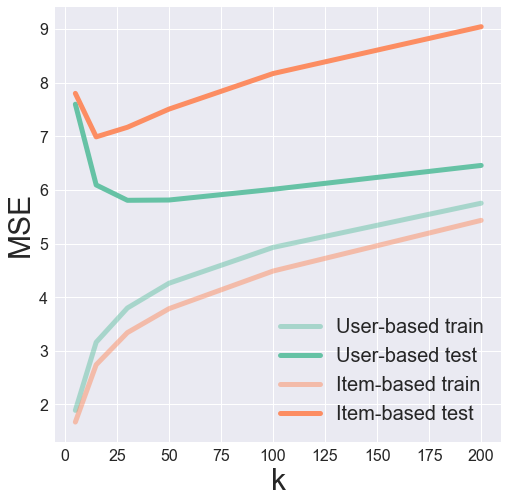

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [43]:
# Load in movie data
idx_to_movie = {}
with open('u.item', 'r') as f:
    for line in open('u.item', encoding = "ISO-8859-1"):
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [44]:
idx = 0 # Toy Story
movies = top_k_movies(item_similarity, idx_to_movie, idx)

In [45]:
print(movies)

['http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)', 'http://us.imdb.com/M/title-exact?Star%20Wars%20(1977)', 'http://us.imdb.com/M/title-exact?Return%20of%20the%20Jedi%20(1983)', 'http://us.imdb.com/M/title-exact?Independence%20Day%20(1996)', 'http://us.imdb.com/M/title-exact?Rock,%20The%20(1996)', 'http://us.imdb.com/M/title-exact?Raiders%20of%20the%20Lost%20Ark%20(1981)']


references:
1. https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
2. http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
3. https://github.com/bradleypallen/keras-movielens-cf
4. https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html
5. https://beckernick.github.io/matrix-factorization-recommender/
6. https://blog.dominodatalab.com/recommender-systems-collaborative-filtering/